In [68]:
import cv2
import numpy as np

In [69]:
import cv2
import numpy as np
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch
from transformers.utils import logging
logging.set_verbosity_info()


In [70]:
# Load model & processor
#use base instead of small if bad accuracy irl
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',use_fast=False)
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')


loading configuration file preprocessor_config.json from cache at C:\Users\mahmoud\.cache\huggingface\hub\models--microsoft--trocr-small-handwritten\snapshots\b4648cfa171985a6745f37ddd637e98c0da958ac\preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 384. Converted to {'height': 384, 'width': 384}.
crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image

In [131]:

class BubbleSheetProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.nc = None
        self.image = None
        self.gray = None
        self.warped = None
        self.cropped = None
        self.thresh = None
        self.bubble_contours = None
        self.answer_matrix = None
        self.student_id=None
        self.bubbles_area_x, self.bubbles_area_y, self.bubbles_area_w, self.bubbles_area_h=None,None,None,None
        self.marker_area=None

    def load_image(self):
        self.image = cv2.imread(self.image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def get_id_corner_map(self):
        aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_100)
        parameters = cv2.aruco.DetectorParameters()
        detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

        corners, ids, _ = detector.detectMarkers(self.gray)
        if ids is None or len(ids) < 4:
            raise ValueError("Not all 4 ArUco markers were detected.")

        id_corner_map = {id[0]: corner for id, corner in zip(ids, corners)}

        if 48 in id_corner_map:
            self.nc = 5
        elif 49 in id_corner_map:
            self.nc = 4
        else:
            raise ValueError("Required ArUco marker not found.")
        #give the area of a circle with diameter equals to the edge of a marker
        marker_arr=id_corner_map[30]
        self.marker_area=np.pi*(int(abs(marker_arr[0][1][0]-marker_arr[0][0][0]))/2)**2
        return id_corner_map

    def get_center(self, corner):
        return corner[0].mean(axis=0)

    def get_centroid(self, array):
        return np.array(array).mean(axis=0)

    def get_roi(self, id_corner_map):
        if 48 in id_corner_map:
            ordered_ids = [30, 10, 48, 34]  # TL, TR, BR, BL
        else:  # 49 is guaranteed if 48 isn't
            ordered_ids = [30, 10, 49, 34]

        ordered_pts = [self.get_center(id_corner_map[id]) for id in ordered_ids]
        return np.array(ordered_pts, dtype='float32')

    def get_warped_image(self, src_pts):
        width, height = int(self.image.shape[0] * 0.764), self.image.shape[0]
        dst_pts = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype='float32')

        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        return cv2.warpPerspective(self.image, M, (width, height))

    def get_largest_contour(self, image, drawContour=False):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(
            gray, 255, 
            cv2.ADAPTIVE_THRESH_MEAN_C, 
            cv2.THRESH_BINARY_INV, 
            25, 4
        )
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        largest_contour = max(contours, key=cv2.contourArea)

        if drawContour:
            cv2.drawContours(image, largest_contour, -1, (0, 255, 0), 3)
            cv2.imshow('largest contour', image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        return largest_contour
    
    def warp_paper(self):
        id_corner_map = self.get_id_corner_map()
        roi = self.get_roi(id_corner_map)
        self.warped = self.get_warped_image(roi)

    def preprocess_cropped(self):
        self.bubbles_area_x, self.bubbles_area_y, self.bubbles_area_w, self.bubbles_area_h = cv2.boundingRect(self.get_largest_contour(self.warped))
        self.cropped = self.warped[self.bubbles_area_y+10:self.bubbles_area_y+self.bubbles_area_h-10, 
                                    self.bubbles_area_x+10:self.bubbles_area_x+self.bubbles_area_w-10]
        
        cropped_gray = cv2.cvtColor(self.cropped, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(cropped_gray, (3, 3), 0)

        self.thresh = cv2.adaptiveThreshold(
            blurred, 255, 
            cv2.ADAPTIVE_THRESH_MEAN_C, 
            cv2.THRESH_BINARY_INV, 
            25, 4
        )

    def extract_bubble_contours(self, drawContours=False):
        contours, _ = cv2.findContours(self.thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        bubble_contours = []

        for c in contours:
            area = cv2.contourArea(c)
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = w / float(h)

            if area > self.marker_area and 0.9 < aspect_ratio < 1.1:
                bubble_contours.append(c)

        bubble_contours.sort(key=lambda b: self.get_centroid(b)[0][1])

        for i in range(10):  # 10 rows expected
            start = i * self.nc * 3
            end = (i + 1) * self.nc * 3
            bubble_contours[start:end] = sorted(
                bubble_contours[start:end],
                key=lambda b: self.get_centroid(b)[0][0]
            )

        if drawContours:
            output = self.cropped.copy()
            cv2.drawContours(output, bubble_contours, -1, (0, 255, 0), 2)
            output_resized = cv2.resize(output, (800, int(output.shape[0] * 800 / output.shape[1])))
            cv2.imshow('Detected Bubbles', output_resized)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        self.bubble_contours = bubble_contours

    def get_filled_bubbles_matrix(self):
        extracted = []

        for c in self.bubble_contours:
            mask = np.zeros(self.thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            masked = cv2.bitwise_and(self.thresh, self.thresh, mask=mask)

            total = cv2.countNonZero(mask)
            filled = cv2.countNonZero(masked)
            ratio = filled / total

            extracted.append(1 if ratio > 0.5 else 0)

        self.answer_matrix = np.array(extracted).reshape(-1, self.nc)
    def detect_student_id(self,drawContours=False):
        id_area=self.warped[0:self.bubbles_area_y, int(self.warped.shape[1]*.75):]
        x, y, w, h = cv2.boundingRect(self.get_largest_contour(id_area))
        
        student_id_img=id_area[y+5:y+h-5, x+5:x+w-5]
        
        pixel_values = processor(images=student_id_img, return_tensors="pt").pixel_values
        # Run inference
        generated_ids = model.generate(pixel_values,max_length=14,min_length=4,num_beams =2,early_stopping =True,repetition_penalty=.8)
        self.student_id = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        if drawContours:
            output = id_area.copy()
            cv2.drawContours(output, self.get_largest_contour(id_area), -1, (0, 255, 0), 2)
            output_resized = cv2.resize(output, (800, int(output.shape[0] * 800 / output.shape[1])))
            cv2.imshow('Detected Bubbles', output_resized)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        
    
    def run_pipeline(self):
        self.load_image()
        self.warp_paper()
        self.preprocess_cropped()
        self.extract_bubble_contours()
        self.get_filled_bubbles_matrix()
        self.detect_student_id()
        return self.student_id, self.answer_matrix


In [137]:
import time
s=time.time()
sheet_processor=BubbleSheetProcessor('Downloads/s1.jpg')
print(sheet_processor.run_pipeline())
print(time.time()-s)

('01098255', array([[1, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]]))
0.9106853008270264


In [260]:
def get_results(model_answer_image, *students_answers_images):
    processor=BubbleSheetProcessor(model_answer_image)
    _,mam=processor.run_pipeline()
    
    for student_answer in students_answers_images:
        processor=BubbleSheetProcessor(student_answer)
        student_id,sam=processor.run_pipeline()
        sam==mam
        print(student_id,np.all(sam==mam,axis=1).sum())
        
    

In [261]:
get_results('Downloads/m.jpg','Downloads/s1.jpg')

AttributeError: 'numpy.ndarray' object has no attribute 'generate'

In [262]:
import numpy as np

# Initialize a 30x5 zero array
arr = np.zeros((30, 5), dtype=int)

# Set the "correct" choice for each question
for i in range(30):
    arr[i, i % 5] = 1

print(arr)

# Create model answer (the "correct" one)
model = np.zeros((30, 5), dtype=int)
for i in range(30):
    model[i, i % 5] = 1

# Helper function to generate a believable answer
def generate_student_answer(model, accuracy=0.6):
    answer = np.zeros_like(model)
    for i in range(model.shape[0]):
        if np.random.rand() < accuracy:
            correct_choice = np.argmax(model[i])
        else:
            # Wrong answer, choose randomly excluding the correct one
            choices = list(set(range(5)) - {np.argmax(model[i])})
            correct_choice = np.random.choice(choices)
        answer[i, correct_choice] = 1
    return answer

# Generate 8 individual student answers
students = [generate_student_answer(model, accuracy=np.random.uniform(0.4, 0.8)) for _ in range(8)]

# Now create 2 cheaters
cheater_base = generate_student_answer(model, accuracy=np.random.uniform(0.6, 0.9))
# Optionally, add small noise to simulate slight differences
cheater1 = cheater_base.copy()
cheater2 = cheater_base.copy()

# Introduce a small chance of changing a few answers for realism
for cheat in [cheater1, cheater2]:
    for i in range(30):
        if np.random.rand() < 0.15:  # x% chance to change
            cheat[i] = np.zeros(5)
            cheat[i, np.random.randint(0, 5)] = 1

# Combine all
students.extend([cheater1, cheater2])
np.random.shuffle(students)  # So you don’t know who cheated 😉

# Now `students` is a list of 10 (30×5) answer arrays
# To visualize a specific student's answer, use:
# print(students[0])  # for example


[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


In [263]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate pairwise Hamming distances
distances = []
for i in range(num_students):
    for j in range(i+1, num_students):
        dist = np.sum(students[i] ^ students[j]) / students[i].size  # Normalized Hamming distance
        distances.append(dist)


<Axes: ylabel='Count'>

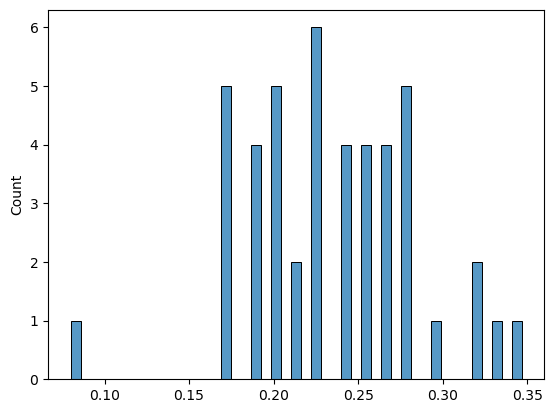

In [264]:
sns.histplot(distances,bins=45)

In [265]:
threshold

0.11

C:\Users\mahmoud\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
C:\Users\mahmoud\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\Users\mahmoud\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


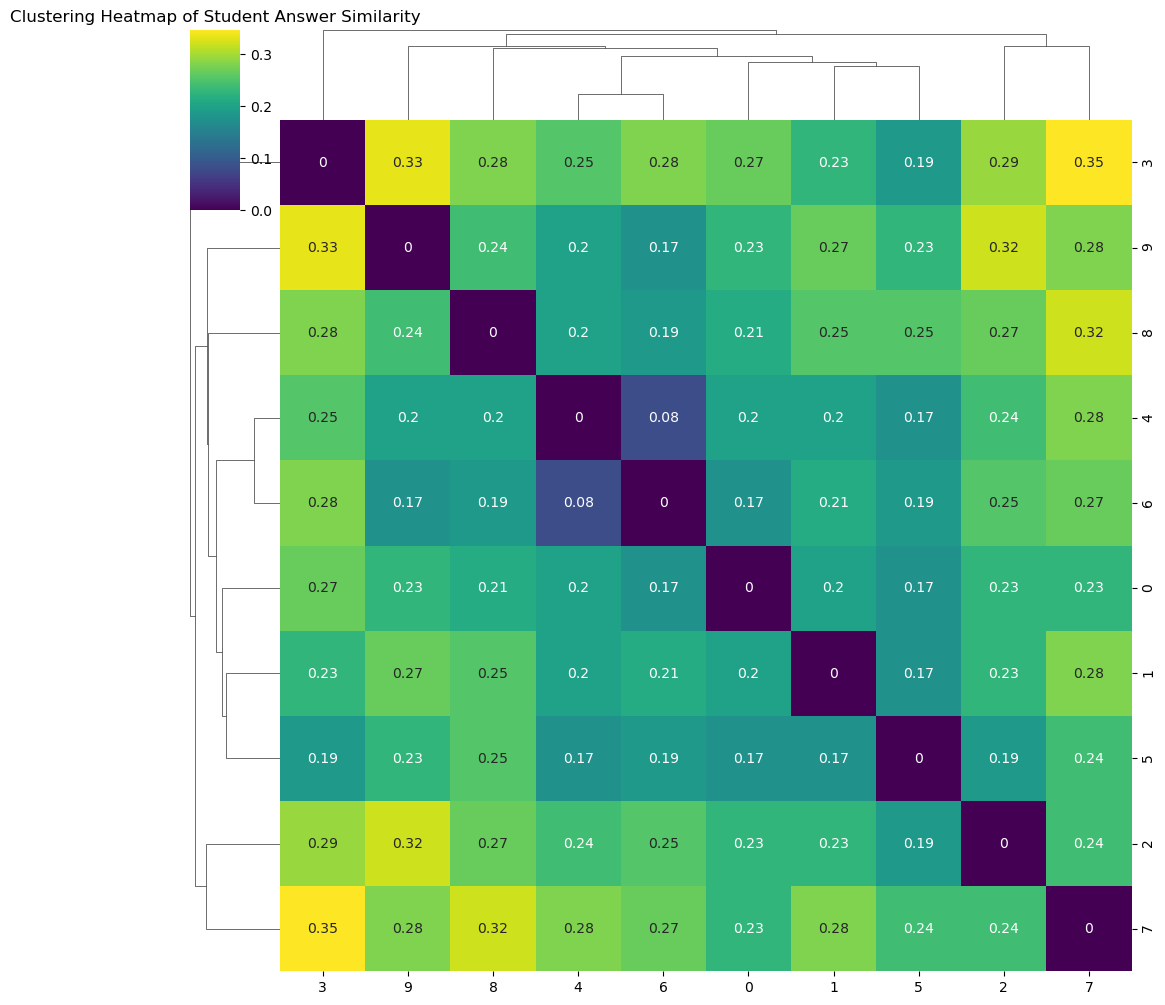

In [266]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Flatten each student's 30x5 matrix into a 150-element vector
flat_students = [student.flatten() for student in students]
data_matrix = np.array(flat_students)

# Compute pairwise Hamming distances
distance_matrix = squareform(pdist(data_matrix, metric='hamming'))

# Plot heatmap with clustering
sns.clustermap(distance_matrix, cmap='viridis', annot=True,  square=True, dendrogram_ratio=(0.1, 0.1),)
plt.title("Clustering Heatmap of Student Answer Similarity")
plt.show()


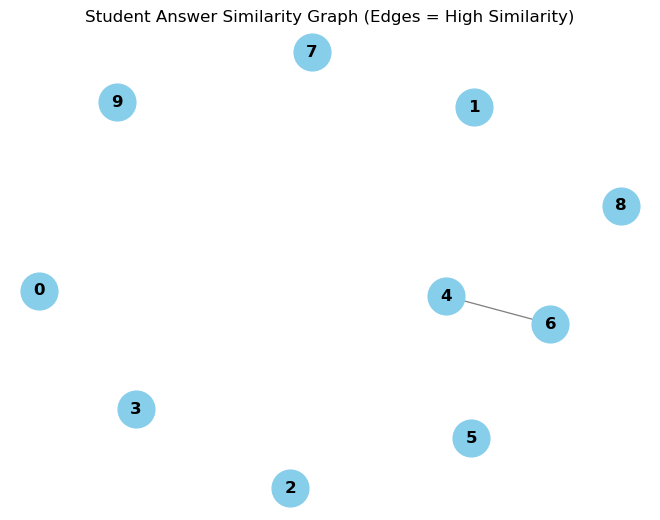

In [270]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.Graph()

# Add nodes (students)
num_students = len(students)
G.add_nodes_from(range(num_students))

# Add weighted edges based on Hamming distance
for i in range(num_students):
    for j in range(i+1, num_students):
        dist = np.sum(students[i] != students[j]) / students[i].size  # Hamming distance
        G.add_edge(i, j, weight=dist)

# Option 1: Filter edges with distance below threshold (suspicious similarity)
threshold =.11#np.mean(distances)-2.7*np.std(distances)
edges_to_draw = [(u, v, d['weight']) for u, v, d in G.edges(data=True) if d['weight'] < threshold]

# Create a new subgraph with only suspiciously similar edges
H = nx.Graph()
H.add_nodes_from(G.nodes)
H.add_weighted_edges_from(edges_to_draw)

# Draw it
pos = nx.spring_layout(H)  # Force-directed layout
edge_weights = [1 - d['weight'] for _, _, d in H.edges(data=True)]  # Higher = stronger similarity

nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=700,
        width=edge_weights, edge_color='gray', font_weight='bold')

plt.title("Student Answer Similarity Graph (Edges = High Similarity)")
plt.show()
